# Wrangling and Analyze Data

## Table of Contents
- [Introduction](#intro)
- [Part I - Data Gathering](#part1)
- [Part II - Assesing Data](#part2)
- [Part III - Cleaning Data](#part3)
- [Part IV - Storing Data](#part4)
- [Part V - Analyzing and Visualizing Data](#part5)

<a id='intro'></a>
# Introduction

The main goal of this project is to gather, clean and analyze data related to the Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.<br>
Data from multiple sources (Twitter's archive, Twitter's API and .tsv file) will be gathered and combined into one dataframe in order to make some insights and visualizations.

------------

<a id='part1'></a>
# Data Gathering

In [1]:
import pandas as pd
import numpy as np
import requests
import json

In [2]:
pd.options.display.max_rows = 3000

#### The WeRateDogs Twitter archive data

In [3]:
dataframe_twitter = pd.read_csv('twitter-archive-enhanced.csv')

#### The tweet image predictions data

In [4]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [5]:
response = requests.get(URL)

In [6]:
with open (URL.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [7]:
dataframe_image = pd.read_csv('image-predictions.tsv', sep='\t')

#### Additional data from the Twitter API

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = dataframe_twitter.tweet_id.values
len(tweet_ids)

count = 0
fails_dict = {}
start = timer()
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [8]:
json_data = [json.loads(line) for line in open('tweet-json.txt', 'r')]

In [9]:
data = []

In [10]:
for i in range(len(json_data)):
    a = json_data[i]['id']
    b = json_data[i]['retweet_count']
    c = json_data[i]['favorite_count']
    data.append([a,b,c])

In [11]:
dataframe_api = pd.DataFrame(data, columns=['id','retweet_count','favorite_count'])

-------------------------------------------------

<a id='part2'></a>
# Assesing Data

## Visual assessment

In [ ]:
dataframe_twitter.head()

In [ ]:
dataframe_image.head()

In [ ]:
dataframe_api.head()

## Programmatic assessement

In [ ]:
dataframe_twitter.info()

In [ ]:
dataframe_twitter.describe()

In [ ]:
dataframe_image.info()

In [ ]:
dataframe_image.describe()

In [ ]:
dataframe_api.info()

In [ ]:
dataframe_api.describe()

## Quality issues

dataframe_twitter:<br>
1. 'timestamp' column should have 'datetime' data type instead of 'object'<br>
2. 'retweeted_status_timestamp' column should have 'datetime' data type instead of 'object'<br>
3. retweets should be removed from the dataframe<br>
4. couple of tweets have rating_numerator value large or small enough to treat them as outliers<br>
5. couple of tweets have rating_denominator not equals to 10<br>
6. 'rating_numerator' for row 45 should be 13.5 instead of 5<br>
7. 'rating_numerator' and 'rating_denominator' for line 2335 should be 9 and 10 respectively insted of 1 and 2<br>
8. dog's name in line 118 should be 'None' instead of 'quite'<br>
9. all 'None' values in 'name' column should represent missing value

## Tidiness issues

10. 'doggo', 'floofer', 'pupper', 'puppo' columns of dataframe_twitter dataframe should be combined into one column<br>
11. Information about dog's breed can be found in three different columns of dataframe_image dataframe ('p1','p2','p3')<br>
12. One dataframe instead of three would be sufficient

--------------------------------------

<a id='part3'></a>
# Cleaning Data

## dataframes' copies:

In [12]:
df_twitter = dataframe_twitter.copy()

In [13]:
df_image = dataframe_image.copy()

In [14]:
df_api = dataframe_api.copy()

## Issue #3:

### Define:

Retweets should be removed from the dataframe.

### Code:

In [15]:
df_twitter = df_twitter[df_twitter.retweeted_status_id.isnull()]

### Test:

In [16]:
df_twitter.retweeted_status_id.notnull().sum()

0

## Issues #1, #2, #6, #7, #8:

### Define:

- data type in 'retweeted_status_timestamp' and 'timestamp' columns should be corrected to datetime data type

- 'rating_numerator' for row 45 should be 13.5 instead of 5

- 'rating_numerator' and 'rating_denominator' for line 2335 should be 9 and 10 respectively insted of 1 and 2

- dog's name in line 118 should be 'None' instead of 'quite'

### Code:

In [17]:
df_twitter['timestamp'] = pd.to_datetime(df_twitter['timestamp'])
df_twitter['retweeted_status_timestamp'] = pd.to_datetime(df_twitter['retweeted_status_timestamp'])

In [18]:
df_twitter.loc[45, 'rating_numerator'] = 13.5

In [19]:
df_twitter.loc[2335, 'rating_numerator'] = 9
df_twitter.loc[2335, 'rating_denominator'] = 10

In [20]:
df_twitter.loc[118, 'name'] = 'None'

### Test:

In [ ]:
df_twitter.info()

In [ ]:
df_twitter.loc[45]

In [ ]:
df_twitter.loc[2335]

In [ ]:
df_twitter.loc[118]

## Issue #4:

### Define:

Couple of tweets have rating_numerator value large or small enough to treat them as outliers.<br>
I will remove all the rows with rating_numerator value smaller than Q1-1.5\*IQR and larger than Q3+1.5\*IQR where Q1 and Q3 are first and third quartile respectively and IQR equals Q3-Q1.<br>

### Code:

In [21]:
IQR = df_twitter.rating_numerator.quantile(0.75) - df_twitter.rating_numerator.quantile(0.25)

In [22]:
numerator_upper_limit = df_twitter.rating_numerator.quantile(0.75) + 1.5*IQR
numerator_lower_limit = df_twitter.rating_numerator.quantile(0.25) - 1.5*IQR

In [23]:
df_twitter = df_twitter[df_twitter.rating_numerator < numerator_upper_limit]
df_twitter = df_twitter[df_twitter.rating_numerator > numerator_lower_limit]

### Test:

In [ ]:
df_twitter.rating_numerator.describe()

## Issue #5:

### Define:

Couple of tweets have rating_denominator not equals to 10 which makes the rating_numerator impossible to interpret. I will update both rating_numerator and rating_denominator for these lines so that rating_denominator equals 10 and I will keep the same proportion between rating_numerator and rating_denominator.

In [25]:
df_twitter[df_twitter.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,8.320886e+17,8.320875e+17,30582082.0,2017-02-16 04:45:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaT,NaN,11.0,15.0,None,None,None,None,None
1068,7.403732e+17,NaN,NaN,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/740373189...,9.0,11.0,None,None,None,None,None


### Code:

In [26]:
df_twitter.loc[342, 'rating_denominator'] = 10
df_twitter.loc[1068, 'rating_denominator'] = 10

In [27]:
df_twitter.loc[342, 'rating_numerator'] = 11/15*10
df_twitter.loc[1068, 'rating_numerator'] = 9/11*10

### Test:

In [ ]:
df_twitter.loc[342]

In [ ]:
df_twitter.loc[1068]

In [28]:
df_twitter[df_twitter.rating_denominator != 10].count().sum()

0

## Issue #9:

### Define:

All 'None' values in 'name' column should represent missing value. I will replace 'None' with NaN.

### Code:

In [29]:
df_twitter.name.replace('None',np.nan,inplace=True)

### Test:

In [30]:
df_twitter[df_twitter['name']=='None'].count().sum()

0

-----------------------

## Issue #10:

### Define:

Information about dog's stage should be placed in one column. I will combine 'doggo', 'floofer', 'pupper', 'puppo' columns into one column called 'stage'. I will also replace empty cells with NaN values.

### Code:

In [31]:
df_twitter.doggo.replace('None','',inplace=True)
df_twitter.floofer.replace('None','',inplace=True)
df_twitter.pupper.replace('None','',inplace=True)
df_twitter.puppo.replace('None','',inplace=True)

In [32]:
df_twitter['stage'] = df_twitter['doggo'] + df_twitter['floofer'] + df_twitter['pupper'] + df_twitter['puppo']

In [33]:
df_twitter.stage.replace('',np.nan,inplace=True)

In [34]:
df_twitter.stage.value_counts()

pupper          212
doggo            75
puppo            24
doggopupper       9
floofer           9
doggopuppo        1
doggofloofer      1
Name: stage, dtype: int64

- As we can find above there are some rows with mixed stages (doggopupper, doggopuppo and doggofloofer). This is because some pictures include more than one dog. I will replace these cells with NaN values.

In [35]:
wrong_stages = ['doggopupper', 'doggopuppo', 'doggofloofer']
for i in wrong_stages:
    df_twitter.stage.replace(i,np.nan,inplace=True)

### Test:

In [36]:
df_twitter.stage.value_counts()

pupper     212
doggo       75
puppo       24
floofer      9
Name: stage, dtype: int64

In [37]:
df_twitter.stage.isnull().sum()

1654

----------------

## Issue #11:

### Define:

Information about dog's breed can be found in three different columns ('p1','p2','p3'). If 'p1' is not a dog I will try to find dog's breed in columns 'p2' and 'p3'. I will place this information in one column called 'breed'.

### Code:

In [38]:
df_image['breed'] = np.nan
for i in range(df_image.shape[0]):
    is_dog1 = df_image.at[i,'p1_dog']
    is_dog2 = df_image.at[i,'p2_dog']
    is_dog3 = df_image.at[i,'p3_dog']
    if is_dog1 == True:
        df_image.loc[[i],['breed']] = df_image.at[i,'p1']
    elif is_dog2 == True:
        df_image.loc[[i],['breed']] = df_image.at[i,'p2']
    elif is_dog3 == True:
        df_image.loc[[i],['breed']] = df_image.at[i,'p3']

### Test:

In [ ]:
df_image.head(30)

----------------

## Issue #12:

### Define:

One dataframe (df_master) instead of three would be sufficient. Both merges will be the 'outer' merges since at this point I do not want to lose any data.<br>
df_master dataframe will have the following columns:<br>'tweet_id'<br>'rating_numerator'<br>'retweet_count'<br>'favorite_count'<br>'stage'<br>'breed'<br>

### Code:

In [41]:
df_twitter_image = df_twitter.merge(df_image, left_on='tweet_id', right_on='tweet_id', how='outer')

In [42]:
df_master = df_twitter_image.merge(df_api, left_on='tweet_id', right_on='id', how='outer')[['tweet_id','rating_numerator','retweet_count','favorite_count','stage','breed']]

### Test:

In [43]:
df_master.head()

,tweet_id,rating_numerator,retweet_count,favorite_count,stage,breed
0,8.924206e+17,13.0,NaN,NaN,NaN,NaN
1,8.924206e+17,NaN,NaN,NaN,NaN,NaN
2,8.921774e+17,13.0,NaN,NaN,NaN,NaN
3,8.921774e+17,NaN,NaN,NaN,NaN,Chihuahua
4,8.918152e+17,12.0,4328.0,25461.0,NaN,Chihuahua


-------------

<a id='part4'></a>
# Storing Data

In [44]:
df_master.to_csv('twitter_archive_master.csv',index=False)

--------------

<a id='part5'></a>
# Analyzing and Visualizing Data

## Insight #1:

In [45]:
df_master.groupby(['stage'])['rating_numerator'].mean()

stage
doggo      11.853333
floofer    11.888889
pupper     10.962264
puppo      12.041667
Name: rating_numerator, dtype: float64

**The puppo stage has the highest average rating.**

## Insight #2:

In [46]:
df_master.groupby(['stage'])['retweet_count'].mean()

stage
doggo      4548.022727
floofer    2298.500000
pupper     2235.470199
puppo      4577.235294
Name: retweet_count, dtype: float64

**The puppo stage has the highest average number of retweets.**

## Insight #3:

In [47]:
df_master.groupby(['stage'])['favorite_count'].mean()

stage
doggo      13336.454545
floofer     5913.750000
pupper      6623.874172
puppo      14867.941176
Name: favorite_count, dtype: float64

**The puppo stage has the highest average number of people who liked the tweet.**

## Insight #4:

For breeds that appear more than 10 times let's find out which breed performs best:

- creation of dataframe with breeds that appear more than 10 times:

In [48]:
df_breed_count = df_master.groupby(['breed'])[['tweet_id','breed']].count()

In [49]:
df_breed_count_morethan10 = df_breed_count[df_breed_count.tweet_id > 10]

- creation of dataframe with average performance for each breed:

In [50]:
df_breed_performance = df_master.groupby(['breed'])[['rating_numerator','retweet_count','favorite_count']].mean()

- dataframe with average performance for breeds that appear more than 10 times:

In [51]:
df_breed = pd.merge(df_breed_count_morethan10, df_breed_performance, left_index=True, right_index=True, how='left')[['rating_numerator','retweet_count','favorite_count']]

--------------------

In [52]:
df_breed.sort_values(by=['rating_numerator'],ascending=False).head(3)

,rating_numerator,retweet_count,favorite_count
breed,,,
Siberian_husky,12.000000,2231.090909,9529.545455
borzoi,11.750000,1211.428571,3068.000000
Samoyed,11.666667,3868.590909,12626.227273


**Siberian_husky, borzoi and Samoyed are the breeds that had the highest average rating.**

-------------------

In [53]:
df_breed.sort_values(by=['retweet_count'],ascending=False).head(3)

,rating_numerator,retweet_count,favorite_count
breed,,,
standard_poodle,11.000000,13328.428571,17490.142857
whippet,10.000000,5311.222222,13935.666667
Cardigan,11.285714,4988.352941,12395.647059


**standard_poodle, whippet and Cardigan are the breeds that had the highest average number of retweets.**

--------------------------

In [54]:
df_breed.sort_values(by=['favorite_count'],ascending=False).head(3)

,rating_numerator,retweet_count,favorite_count
breed,,,
standard_poodle,11.000000,13328.428571,17490.142857
French_bulldog,11.136364,4284.363636,15596.000000
basset,11.666667,3178.500000,14656.400000


**standard_poodle, French_bulldog and basset are the breeds that had the highest average number of likes.**

##  Visualization #1:

**Above scatter plot shows that number of people who retweeted the tweet is positively correlated with tweet's rating.**

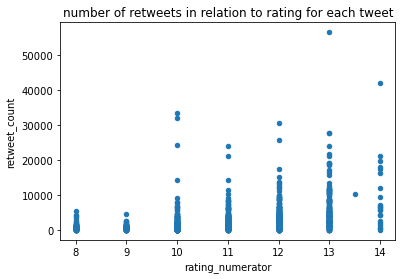

In [58]:
df_master.plot(x='rating_numerator',y='retweet_count',kind='scatter', title='number of retweets in relation to rating for each tweet');

##  Visualization #2:

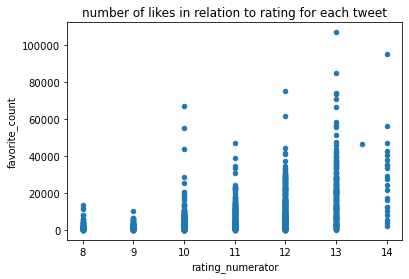

In [59]:
df_master.plot(x='rating_numerator',y='favorite_count',kind='scatter', title='number of likes in relation to rating for each tweet');

**Above scatter plot shows that number of people who liked the tweet is positively correlated with tweet's rating.**